In [0]:
#Importing Libraries
from pyspark.sql.window import Window
from pyspark.sql.types import *
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import monotonically_increasing_id, desc, row_number

from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as F
from pyspark.sql.functions import col, row_number

from pyspark.sql.functions import (col, max as max_, struct, monotonically_increasing_id)

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator


In [0]:
sales = spark.read.csv('/FileStore/tables/sales_train_evaluation__1_-1.csv', header="true", inferSchema="true")
calendar = spark.read.csv('/FileStore/tables/calendar.csv', header="true", inferSchema="true")
prices = spark.read.csv('/FileStore/tables/sell_prices.csv', header="true", inferSchema="true")
print((sales.count(), len(sales.columns)))

(30490, 1947)

In [0]:
#grouping by categories and transposing
sales = spark.createDataFrame(
                                sales.groupby('cat_id').sum() \
                                .toPandas().set_index("cat_id") \
                                .transpose().reset_index().rename(columns={'index': 'Day'})
                             )
#joining date to sales to display dates in place of 'd'
w1 = Window.orderBy("Day")
w2= Window.orderBy("Date")

df1 = sales.select('*').withColumn('index', row_number().over(w1))
df2 =  calendar.limit(1941).withColumn('index', row_number().over(w2))

sales = df2.select('Date', 'index').join(df1, df1.index== df2.index).select('Date', "FOODS", "HOUSEHOLD", "HOBBIES")


#getting weekly aggregate
sales = sales.groupBy(F.window(("Date"), "1 week", "1 week")).sum().select("window.start", "window.end", "sum(FOODS)",'sum(HOBBIES)','sum(HOUSEHOLD)')

#creating separate time series for each
foods = sales.select('start','sum(FOODS)').withColumnRenamed('start','week_start').withColumnRenamed('sum(FOODS)','foods')
hobbies = sales.select('start','sum(HOBBIES)').withColumnRenamed('start','week_start').withColumnRenamed('sum(HOBBIES)','hobbies')
household = sales.select('start','sum(HOUSEHOLD)').withColumnRenamed('start','week_start').withColumnRenamed('sum(HOUSEHOLD)','household')

In [0]:
display(foods)

week_start,foods
2011-01-27T00:00:00.000+0000,100366
2011-02-03T00:00:00.000+0000,162086
2011-02-10T00:00:00.000+0000,175839
2011-02-17T00:00:00.000+0000,171956
2011-02-24T00:00:00.000+0000,162959
2011-03-03T00:00:00.000+0000,147608
2011-03-10T00:00:00.000+0000,141768
2011-03-17T00:00:00.000+0000,183323
2011-03-24T00:00:00.000+0000,168404
2011-03-31T00:00:00.000+0000,161055


In [0]:
def create_pipeline(df,cols):
  
  stages = []
  assemblerInputs = cols
  feature_assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
  stages += [feature_assembler]
  
  pipeline = Pipeline(stages = stages)
  pipelineModel = pipeline.fit(df)
  df_transformed = pipelineModel.transform(df)
  selectedCols = ['features'] + df.columns
  df_transformed = df_transformed.select(selectedCols)
  
  return df_transformed

In [0]:
#RMSE is predifined
#creating function for sMAPE

def smape(y_true,y_pred): 
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [0]:
#adding weeks column
foods = foods.withColumn('week',monotonically_increasing_id())

#creating lag as feature
w_lag = Window.orderBy('week_start')
foods = foods.withColumn('last_week_value', F.lag(F.col('foods')).over(w_lag))
foods = foods.na.drop()

#renaming columns
foods = foods.selectExpr("week_start as week_start", 'week as week',"foods as target",'last_week_value as last_week_value')

#max number of weeks
foods.select(F.max(F.col("week")).alias("MAX")).limit(1).collect()[0].MAX

Out[88]: 277

In [0]:
display(foods)

week_start,week,target,last_week_value
2011-02-03T00:00:00.000+0000,1,162086,100366
2011-02-10T00:00:00.000+0000,2,175839,162086
2011-02-17T00:00:00.000+0000,3,171956,175839
2011-02-24T00:00:00.000+0000,4,162959,171956
2011-03-03T00:00:00.000+0000,5,147608,162959
2011-03-10T00:00:00.000+0000,6,141768,147608
2011-03-17T00:00:00.000+0000,7,183323,141768
2011-03-24T00:00:00.000+0000,8,168404,183323
2011-03-31T00:00:00.000+0000,9,161055,168404
2011-04-07T00:00:00.000+0000,10,133463,161055


In [0]:
#Assembling Pipeline and Transforming foods data using pipeline
cols = ['last_week_value']
foods_transformed = create_pipeline(foods,cols)

#train test split
train = foods_transformed.where(F.col('week')<256).orderBy('week_start')
test = foods_transformed.where(F.col('week')>=256).orderBy('week_start')

In [0]:

#linear Regression and Evaluation
lr = LinearRegression(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")


  
# We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
model = crossval.fit(train)

#getting predictions and computing metrics
predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)
#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

RMSE: 22710.040884735008
SMAPE: 9.536123933134888

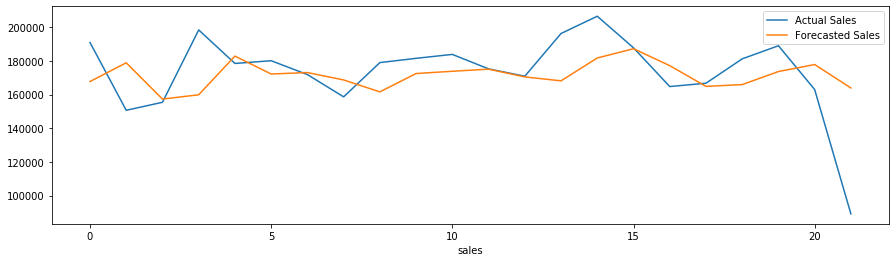

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()

In [0]:

#Random Forest Regression and Evaluation
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")


  
# We use a ParamGridBuilder to construct a grid of parameters to search over.

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [3, 5, 10]) \
    .addGrid(rf.maxDepth, [3, 5, 7])\
    .build()


# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
model = crossval.fit(train)

#getting predictions and computing metrics
predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)
#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
RMSE: 22550.45552953152
SMAPE: 9.7706297546185

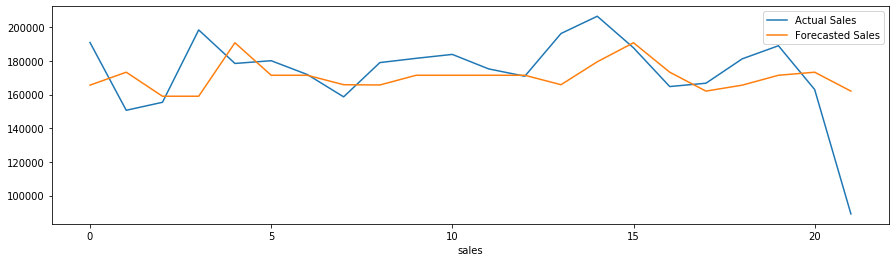

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()

In [0]:

#Gradient Boosted Regression and Evaluation
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")

  
# We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [3, 5, 7])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
model = crossval.fit(train)

#getting predictions and computing metrics

predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)
#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
RMSE: 22745.274635860133
SMAPE: 9.81052175492556

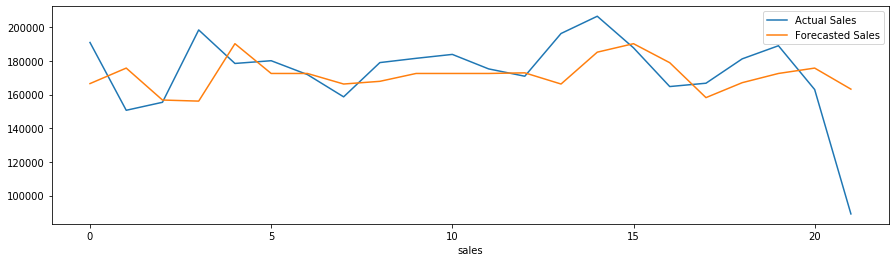

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()

In [0]:
#dropping features column
foods = foods.drop('last_week_value')

In [0]:
def create_features(df):
  weeks = lambda i: i * 86400 *7

  w_lag = Window.orderBy('week_start')
  w_moving = Window.orderBy(F.col('week_start').cast('long')).rangeBetween(-weeks(4), 0)

  df = df.withColumn('week_of_year', F.weekofyear(F.col("week_start"))) \
                  .withColumn('month', F.month(F.col('week_start'))) \
                  .withColumn('last_week_value', F.lag(F.col('target')).over(w_lag)) \
                  .withColumn('last_week_diff', F.lag(F.col('target')).over(w_lag) - F.lag(F.col('target'),2).over(w_lag)) \
                    .withColumn('last_2week_value', F.lag(F.col('target'),2).over(w_lag)) \
                  .withColumn('last_2week_diff', F.lag(F.col('target'),2).over(w_lag) - F.lag(F.col('target'),3).over(w_lag)) \
                    .withColumn('last_3week_value', F.lag(F.col('target'),3).over(w_lag)) \
                  .withColumn('last_3week_diff', F.lag(F.col('target'),3).over(w_lag) - F.lag(F.col('target'),4).over(w_lag)) \
                    .withColumn('last_4week_value', F.lag(F.col('target'),4).over(w_lag)) \
                  .withColumn('last_4week_diff', F.lag(F.col('target'),4).over(w_lag) - F.lag(F.col('target'),5).over(w_lag)) \
                    .withColumn('last_5week_value', F.lag(F.col('target'),5).over(w_lag)) \
                  .withColumn('last_5week_diff', F.lag(F.col('target'),5).over(w_lag) - F.lag(F.col('target'),6).over(w_lag)) \
                    .withColumn('last_6week_value', F.lag(F.col('target'),6).over(w_lag)) \
                  .withColumn('last_6week_diff', F.lag(F.col('target'),6).over(w_lag) - F.lag(F.col('target'),7).over(w_lag)) \
                    .withColumn('last_7week_value', F.lag(F.col('target'),7).over(w_lag)) \
                  .withColumn('last_7week_diff', F.lag(F.col('target'),7).over(w_lag) - F.lag(F.col('target'),8).over(w_lag)) \
                    .withColumn('last_8week_value', F.lag(F.col('target'),8).over(w_lag)) \
                  .withColumn('last_8week_diff', F.lag(F.col('target'),8).over(w_lag) - F.lag(F.col('target'),9).over(w_lag)) \
                    .withColumn('last_9week_value', F.lag(F.col('target'),9).over(w_lag)) \
                  .withColumn('last_9week_diff', F.lag(F.col('target'),9).over(w_lag) - F.lag(F.col('target'),10).over(w_lag)) \
                      .withColumn('last_10week_value', F.lag(F.col('target'),10).over(w_lag)) \
                  .withColumn('last_10week_diff', F.lag(F.col('target'),10).over(w_lag) - F.lag(F.col('target'),11).over(w_lag)) \
                      .withColumn('last_11week_value', F.lag(F.col('target'),11).over(w_lag)) \
                  .withColumn('last_11week_diff', F.lag(F.col('target'),11).over(w_lag) - F.lag(F.col('target'),12).over(w_lag)) \
                      .withColumn('last_12week_value', F.lag(F.col('target'),12).over(w_lag)) \
                  .withColumn('last_12week_diff', F.lag(F.col('target'),12).over(w_lag) - F.lag(F.col('target'),13).over(w_lag)) \
                    .withColumn('moving_average_4weeks', F.avg('last_week_value').over(w_moving)) \
                  .withColumn('moving_std_4weeks', F.stddev('last_week_value').over(w_moving))

  
  df = df.na.drop()
  
  return df

In [0]:
foods_features = create_features(foods)

In [0]:
display(foods_features)

week_start,week,target,week_of_year,month,last_week_value,last_week_diff,last_2week_value,last_2week_diff,last_3week_value,last_3week_diff,last_4week_value,last_4week_diff,last_5week_value,last_5week_diff,last_6week_value,last_6week_diff,last_7week_value,last_7week_diff,last_8week_value,last_8week_diff,last_9week_value,last_9week_diff,last_10week_value,last_10week_diff,last_11week_value,last_11week_diff,last_12week_value,last_12week_diff,moving_average_4weeks,moving_std_4weeks
2011-05-05T00:00:00.000+0000,14,154945,18,5,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,141768,-5840,147608,-15351,162959,-8997,171956,-3883,175839,13753,161527.8,18073.50980579035
2011-05-12T00:00:00.000+0000,15,149255,19,5,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,141768,-5840,147608,-15351,162959,-8997,171956,-3883,160305.8,18318.367304429725
2011-05-19T00:00:00.000+0000,16,159054,20,5,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,141768,-5840,147608,-15351,162959,-8997,163464.2,13171.533118813468
2011-05-26T00:00:00.000+0000,17,177364,21,5,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,141768,-5840,147608,-15351,163483.6,13163.303814012652
2011-06-02T00:00:00.000+0000,18,169698,22,6,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,141768,-5840,162788.0,12062.570476478055
2011-06-09T00:00:00.000+0000,19,144376,23,6,169698,-7666,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,183323,41555,162063.2,11359.783171346186
2011-06-16T00:00:00.000+0000,20,158302,24,6,144376,-25322,169698,-7666,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,168404,-14919,159949.4,13747.783595911016
2011-06-23T00:00:00.000+0000,21,162795,25,6,158302,13926,144376,-25322,169698,-7666,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,161055,-7349,161758.8,12529.76764349603
2011-06-30T00:00:00.000+0000,22,181695,26,6,162795,4493,158302,13926,144376,-25322,169698,-7666,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,133463,-27592,162507.0,12439.242943201969
2011-07-07T00:00:00.000+0000,23,168147,27,7,181695,18900,162795,4493,158302,13926,144376,-25322,169698,-7666,177364,18310,159054,9799,149255,-5690,154945,-18377,173322,-7520,180842,21885,158957,25494,163373.2,13807.936511296684


In [0]:
foods_features.schema.names

Out[121]: ['week_start',
 'week',
 'target',
 'week_of_year',
 'month',
 'last_week_value',
 'last_week_diff',
 'last_2week_value',
 'last_2week_diff',
 'last_3week_value',
 'last_3week_diff',
 'last_4week_value',
 'last_4week_diff',
 'last_5week_value',
 'last_5week_diff',
 'last_6week_value',
 'last_6week_diff',
 'last_7week_value',
 'last_7week_diff',
 'last_8week_value',
 'last_8week_diff',
 'last_9week_value',
 'last_9week_diff',
 'last_10week_value',
 'last_10week_diff',
 'last_11week_value',
 'last_11week_diff',
 'last_12week_value',
 'last_12week_diff',
 'moving_average_4weeks',
 'moving_std_4weeks']

In [0]:
inputs = ['week_of_year','month']
encoder = OneHotEncoder(inputCols=inputs, outputCols=["week_of_year_enc", "month_enc"])
pipeline = Pipeline(stages=[ encoder])
foods_features = pipeline.fit(foods_features).transform(foods_features)

In [0]:
#Assembling Pipeline and Transforming foods data using pipeline
cols = ['week_of_year_enc','month_enc','last_week_value','last_week_diff','last_2week_value','last_2week_diff','last_3week_value','last_3week_diff','last_4week_value','last_4week_diff','last_5week_value','last_5week_diff',
       'last_6week_value','last_6week_diff','last_7week_value','last_7week_diff','last_8week_value','last_8week_diff','last_9week_value','last_9week_diff','last_10week_value','last_10week_diff','last_11week_value',
        'last_11week_diff','last_12week_value','last_12week_diff','moving_average_4weeks','moving_std_4weeks']
foods_features_transformed = create_pipeline(foods_features,cols)

#train test split
train = foods_features_transformed.where(F.col('week')<256).orderBy('week_start')
test = foods_features_transformed.where(F.col('week')>=256).orderBy('week_start')


In [0]:
foods_features_transformed.show()

+--------------------+-------------------+----+------+------------+-----+---------------+--------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+-----------------+----------------+-----------------+----------------+---------------------+------------------+----------------+--------------+
 features| week_start|week|target|week_of_year|month|last_week_value|last_week_diff|last_2week_value|last_2week_diff|last_3week_value|last_3week_diff|last_4week_value|last_4week_diff|last_5week_value|last_5week_diff|last_6week_value|last_6week_diff|last_7week_value|last_7week_diff|last_8week_value|last_8week_diff|last_9week_value|last_9week_diff|last_10week_value|last_10week_diff|last_11week_value|last_11week_diff|last_12week_value|last_12week_diff|moving_average_4weeks| moving_std_4weeks|week_of_year_enc| month_enc|
+--------------------+-------------------+----+------+------------+-----+---------------+--------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+-----------------+----------------+-----------------+----------------+---------------------+------------------+----------------+--------------+
(91,[18,58,65,66,...|2011-05-05 00:00:00| 14|154945| 18| 5| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 141768| -5840| 147608| -15351| 162959| -8997| 171956| -3883| 175839| 13753| 161527.8| 18073.50980579035| (53,[18],[1.0])|(12,[5],[1.0])|
(91,[19,58,65,66,...|2011-05-12 00:00:00| 15|149255| 19| 5| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 141768| -5840| 147608| -15351| 162959| -8997| 171956| -3883| 160305.8|18318.367304429725| (53,[19],[1.0])|(12,[5],[1.0])|
(91,[20,58,65,66,...|2011-05-19 00:00:00| 16|159054| 20| 5| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 141768| -5840| 147608| -15351| 162959| -8997| 163464.2|13171.533118813468| (53,[20],[1.0])|(12,[5],[1.0])|
(91,[21,58,65,66,...|2011-05-26 00:00:00| 17|177364| 21| 5| 159054| 9799| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 141768| -5840| 147608| -15351| 163483.6|13163.303814012652| (53,[21],[1.0])|(12,[5],[1.0])|
(91,[22,59,65,66,...|2011-06-02 00:00:00| 18|169698| 22| 6| 177364| 18310| 159054| 9799| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 141768| -5840| 162788.0|12062.570476478055| (53,[22],[1.0])|(12,[6],[1.0])|
(91,[23,59,65,66,...|2011-06-09 00:00:00| 19|144376| 23| 6| 169698| -7666| 177364| 18310| 159054| 9799| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 183323| 41555| 162063.2|11359.783171346186| (53,[23],[1.0])|(12,[6],[1.0])|
(91,[24,59,65,66,...|2011-06-16 00:00:00| 20|158302| 24| 6| 144376| -25322| 169698| -7666| 177364| 18310| 159054| 9799| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 168404| -14919| 159949.4|13747.783595911016| (53,[24],[1.0])|(12,[6],[1.0])|
(91,[25,59,65,66,...|2011-06-23 00:00:00| 21|162795| 25| 6| 158302| 13926| 144376| -25322| 169698| -7666| 177364| 18310| 159054| 9799| 149255| -5690| 154945| -18377| 173322| -7520| 180842| 21885| 158957| 25494| 133463| -27592| 161055| -7349| 161758.8| 125

In [0]:

#linear Regression and Evaluation
lr = LinearRegression(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")

  
# We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [1, 0.5, 0.1, 0.05, 0.01, 0.005]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# tvs = TrainValidationSplit(estimator=lr,
#                            estimatorParamMaps=paramGrid,
#                            evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
#                            # 80% of the data will be used for training, 20% for validation.
#                            trainRatio=0.8)

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
# model = tvs.fit(train)
model = crossval.fit(train)

#getting predictions and computing metrics
predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)
#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
RMSE: 19296.396258250665
SMAPE: 8.081148428324173

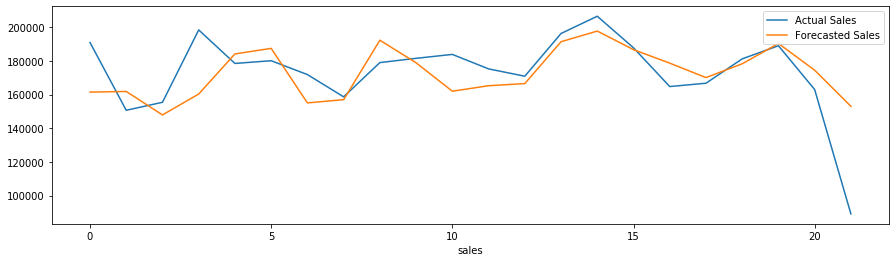

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()

In [0]:
#Random Forest Regression and Evaluation
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")


  
# We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [3, 5, 10]) \
    .addGrid(rf.maxDepth, [3, 5, 7])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
model = crossval.fit(train)

#getting predictions and computing metrics
predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)
#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
RMSE: 19485.536827323736
SMAPE: 7.432035951802182

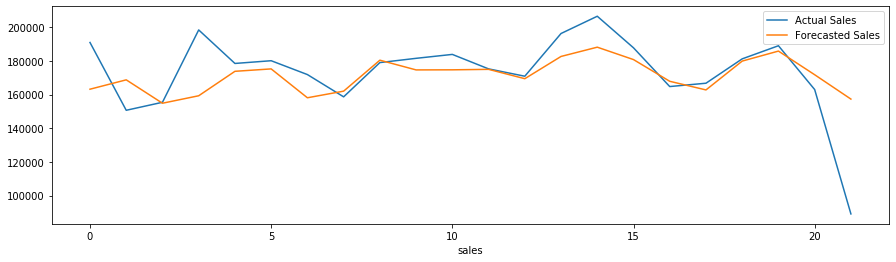

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()

In [0]:

#Gradient Boosted Tree Regression and Evaluation
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'target')
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")

  
# We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [3, 5, 7])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

# Run TrainValidationSplit, and choose the best set of parameters.
model = crossval.fit(train)

#getting predictions and computing metrics
predictions = model.transform(test)
actuals = model.transform(test).select('target').rdd.flatMap(lambda x: x).collect()
preds = model.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()
rmse = evaluator.evaluate(predictions)

preds, actuals = np.array(preds), np.array(actuals)
smape_error = smape(actuals,preds)

#printing metrics
print('RMSE:',rmse)
print('SMAPE:',smape_error)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
RMSE: 24806.196760027608
SMAPE: 11.749139237632983

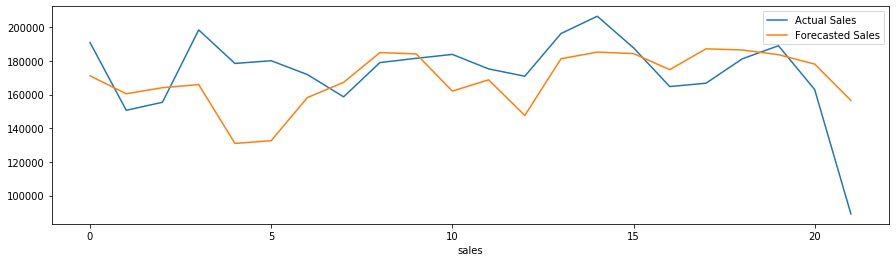

In [0]:
#visualising results
#Plotting the graph
plt.figure(figsize=(15,4))
plt.plot(actuals)
plt.plot(preds)
plt.xlabel('testing weeks')
plt.xlabel('sales')
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
plt.show()